In [1]:
import sys, os
import numpy as np
import pandas as pd
import photoz_utils
import random
import h5py
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm

In [2]:
photozdata = pd.read_csv('/data/HSC/HSC_v6/HSC_v6.csv')
photozdata.describe()

b = np.argsort(photozdata['object_id'])
sorted_photozdata = photozdata.iloc[b][:]
photozdata = sorted_photozdata

In [3]:
for (columnName, columnData) in photozdata.iteritems():
    print(columnName)

object_id
specz_redshift_err
specz_redshift
specz_mag_i
specz_name
specz_ra
specz_dec
specz_flag_homogeneous
ra
dec
coord
skymap_id
g_cmodel_mag
r_cmodel_mag
i_cmodel_mag
z_cmodel_mag
y_cmodel_mag
g_cmodel_magsigma
r_cmodel_magsigma
i_cmodel_magsigma
z_cmodel_magsigma
y_cmodel_magsigma


/tmp/ipykernel_3767701/3463937130.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():


In [4]:
hf_original = h5py.File('/data/HSC/HSC_v6/step2/127x127/five_band_image127x127_with_metadata_corrected.hdf5', 'r')
object_id_original = np.asarray(hf_original['object_id'])[..., None]
size = len(object_id_original)

start_index = (127 - 64) // 2
end_index = start_index + 64

In [5]:
# indices = random.sample(list(np.arange(size)), ntrain + ntest + nval)

In [6]:
ntrain_large = 204573
ntest_large = 40914
nval_large = 40914
if ntrain_large + ntest_large + nval_large != size:
    print('error!')

In [7]:
indices = np.load('datasplit_indices.npy')

In [8]:
inds_train_large = np.sort(indices[: ntrain_large])
inds_test_large = np.sort(indices[ntrain_large : ntrain_large + ntest_large])
inds_val_large = np.sort(indices[ntrain_large + ntest_large :])

In [9]:
hf_split = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64.hdf5', 'r')

In [10]:
tmp = list(hf_split['specz_redshift'])

In [11]:
hf_split.keys()

<KeysViewHDF5 ['coord', 'dec', 'g_cmodel_mag', 'g_cmodel_magsigma', 'i_cmodel_mag', 'i_cmodel_magsigma', 'image', 'object_id', 'r_cmodel_mag', 'r_cmodel_magsigma', 'ra', 'skymap_id', 'specz_dec', 'specz_flag_homogeneous', 'specz_mag_i', 'specz_name', 'specz_ra', 'specz_redshift', 'specz_redshift_err', 'y_cmodel_mag', 'y_cmodel_magsigma', 'z_cmodel_mag', 'z_cmodel_magsigma']>

In [12]:
ntrain = 10000
ntest = 2000
nval = 2000

In [13]:
bins = np.arange(0, 4, 0.5)

inds_list = [inds_train_large, inds_test_large, inds_val_large]

inds_train = np.array([])
inds_test = np.array([])
inds_val = np.array([])

for z_bin in tqdm(bins):
    tmp = list(hf_split['specz_redshift'])
    count = 0
    for i in inds_train_large: 
        if tmp[i] > z_bin and tmp[i] < z_bin + 0.5:
            inds_train = np.append(inds_train, i)
            count = count + 1
        if count == ntrain / 8:
            break
            
for z_bin in tqdm(bins):
    tmp = list(hf_split['specz_redshift'])
    count = 0
    for i in inds_test_large: 
        if tmp[i] > z_bin and tmp[i] < z_bin + 0.5:
            inds_test = np.append(inds_test, i)
            count = count + 1
        if count == ntest / 8:
            break
            
for z_bin in tqdm(bins):
    tmp = list(hf_split['specz_redshift'])
    count = 0
    for i in inds_val_large: 
        if tmp[i] > z_bin and tmp[i] < z_bin + 0.5:
            inds_val = np.append(inds_val, i)
            count = count + 1
        if count == nval / 8:
            break

100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


In [14]:
ntrain = len(inds_train)
ntest = len(inds_test)
nval = len(inds_val)

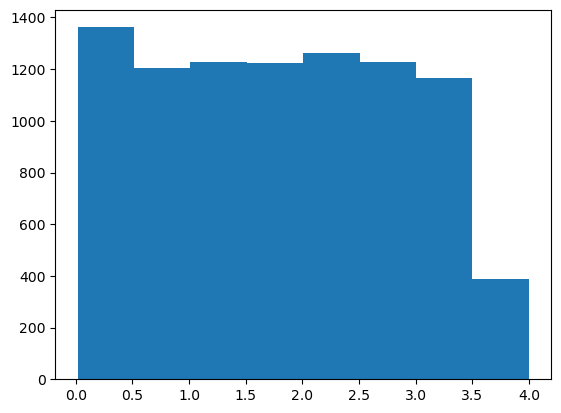

In [15]:
hf_split_z = list(hf_split['specz_redshift'])
inds_train = np.array([int(i) for i in inds_train])
inds_test = np.array([int(i) for i in inds_test])
inds_val = np.array([int(i) for i in inds_val])
plt.hist([hf_split_z[i] for i in inds_train], 8)
plt.show()

In [16]:
# np.save('datasplit_indices_small.npy', indices)

In [17]:
subsizes = [ntrain, ntest, nval]
file_ends = ['_training_small_uniform', '_testing_small_uniform', '_validation_small_uniform']
inds_list = [inds_train, inds_test, inds_val]

for subsize, file_end, inds in zip(subsizes, file_ends, inds_list):
    hf_write = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64' + file_end + '.hdf5', 'w')
    for k in hf_split.keys():
        tmp = hf_split[k]
        subshape = list(np.shape(tmp))
        subshape[0] = subsize
        dataset = hf_write.create_dataset(k, shape = subshape, dtype = tmp.dtype)
        for i, index in tqdm(enumerate(inds)):
            dataset[i] = tmp[index]
        tmp = None

hf_split.close()
hf_write.close()

9062it [00:14, 608.58it/s]  
9062it [00:07, 1272.69it/s] 
9062it [00:13, 679.96it/s]  
9062it [00:07, 1176.09it/s] 
9062it [00:03, 2873.91it/s] 
9062it [00:01, 7646.64it/s] 
9062it [01:02, 146.09it/s]
9062it [00:06, 1406.82it/s] 
9062it [00:00, 13796.17it/s]
9062it [00:00, 17317.84it/s]
9062it [00:07, 1235.20it/s] 
9062it [00:00, 12890.85it/s]
9062it [00:11, 786.47it/s]  
9062it [00:01, 9020.52it/s] 
9062it [00:06, 1409.11it/s] 
9062it [00:01, 7204.96it/s] 
9062it [00:00, 17146.72it/s]
9062it [00:00, 18280.41it/s]
9062it [00:00, 17686.87it/s]
9062it [00:00, 11788.52it/s]
9062it [00:01, 5676.56it/s] 
9062it [00:00, 16979.15it/s]
9062it [00:00, 17843.44it/s]
1806it [00:01, 1262.96it/s]
1806it [00:00, 2507.06it/s]
1806it [00:00, 2063.16it/s] 
1806it [00:00, 4607.43it/s]
1806it [00:00, 14295.96it/s]
1806it [00:00, 14095.43it/s]
1806it [00:12, 148.76it/s]
1806it [00:00, 2470.25it/s]
1806it [00:00, 14267.31it/s]
1806it [00:00, 17624.93it/s]
1806it [00:00, 3331.93it/s] 
1806it [00:00, 16532.7

In [30]:
hf_split = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127.hdf5', 'r')

In [31]:
subsizes = [ntrain, ntest, nval]
file_ends = ['_training_small_uniform', '_testing_small_uniform', '_validation_small_uniform']
inds_list = [inds_train, inds_test, inds_val]

for subsize, file_end, inds in zip(subsizes, file_ends, inds_list):
    hf_write = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127' + file_end + '.hdf5', 'w')
    for k in hf_split.keys():
        tmp = hf_split[k]
        subshape = list(np.shape(tmp))
        subshape[0] = subsize
        dataset = hf_write.create_dataset(k, shape = subshape, dtype = tmp.dtype)
        for i, index in tqdm(enumerate(inds)):
            dataset[i] = tmp[index]
        tmp = None

hf_split.close()
hf_write.close()

9062it [00:00, 12312.67it/s]
9062it [00:00, 20481.97it/s]
9062it [00:00, 20409.95it/s]
9062it [00:00, 20503.98it/s]
9062it [00:00, 20511.91it/s]
9062it [00:00, 20428.33it/s]
9062it [01:12, 124.69it/s] 
9062it [00:00, 21709.33it/s]
9062it [00:00, 21262.14it/s]
9062it [00:00, 21470.15it/s]
9062it [00:00, 21345.21it/s]
9062it [00:00, 22086.47it/s]
9062it [00:00, 22382.90it/s]
9062it [00:00, 13531.71it/s]
9062it [00:00, 22352.07it/s]
9062it [00:00, 14136.02it/s]
9062it [00:00, 21514.27it/s]
9062it [00:00, 22353.62it/s]
9062it [00:00, 22158.28it/s]
9062it [00:00, 22543.24it/s]
9062it [00:00, 21903.04it/s]
9062it [00:00, 21415.76it/s]
9062it [00:00, 21811.46it/s]
1806it [00:00, 10846.69it/s]
1806it [00:00, 22213.43it/s]
1806it [00:00, 22178.70it/s]
1806it [00:00, 22231.10it/s]
1806it [00:00, 22138.32it/s]
1806it [00:00, 22118.99it/s]
1806it [00:03, 480.91it/s]
1806it [00:00, 21840.74it/s]
1806it [00:00, 20962.35it/s]
1806it [00:00, 21918.40it/s]
1806it [00:00, 22032.20it/s]
1806it [00:00, 22

In [32]:
hf_original = h5py.File('/data/HSC/HSC_v6/step2/127x127/five_band_image127x127_with_metadata_corrected.hdf5', 'r')
object_id_original = np.asarray(hf_original['object_id'])[..., None]
size = len(object_id_original)

start_index = (127 - 64) // 2
end_index = start_index + 64

In [33]:
hf_train_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_training_small_uniform.hdf5', 'r')
hf_train_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_training_small_uniform.hdf5', 'r')

In [34]:
# Check data maching
for (columnName, columnData) in tqdm(photozdata.iteritems()):
    # print(np.asarray(hf_original[columnName])[..., None][0:2])
    for i in range(0, 10):
        if np.asarray(hf_train_64[columnName])[..., None][i] != np.asarray(hf_train_127[columnName])[..., None][i]:
            print('error')

22it [00:00, 344.28it/s]


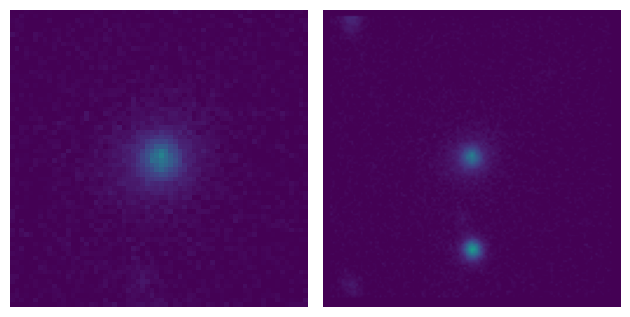

In [35]:
# Check image maching
index_to_show = 400
fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns

axes[0].imshow(hf_train_64['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[0].axis('off')

axes[1].imshow(hf_train_127['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

22it [00:00, 186.92it/s]


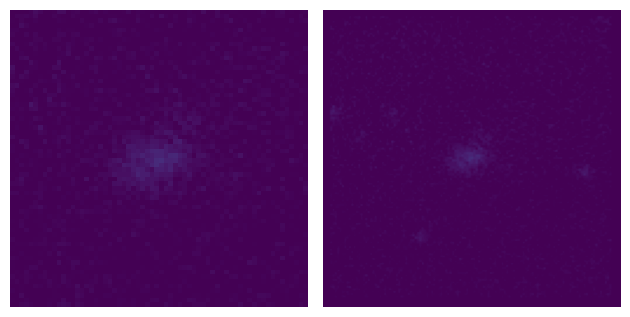

In [37]:
hf_test_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_testing_small_uniform.hdf5', 'r')
hf_test_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_testing_small_uniform.hdf5', 'r')

# Check data maching
for (columnName, columnData) in tqdm(photozdata.iteritems()):
    # print(np.asarray(hf_original[columnName])[..., None][0:2])
    for i in range(0, 10):
        if np.asarray(hf_test_64[columnName])[..., None][i] != np.asarray(hf_test_127[columnName])[..., None][i]:
            print('error')
            
# Check image maching
index_to_show = 400
fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns

axes[0].imshow(hf_test_64['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[0].axis('off')

axes[1].imshow(hf_test_127['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

22it [00:00, 132.40it/s]


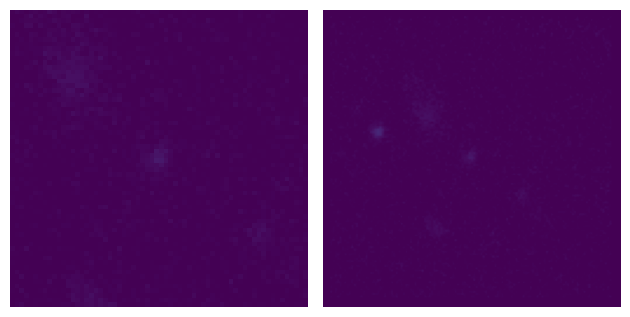

In [38]:
hf_val_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_validation_small_uniform.hdf5', 'r')
hf_val_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_validation_small_uniform.hdf5', 'r')

# Check data maching
for (columnName, columnData) in tqdm(photozdata.iteritems()):
    # print(np.asarray(hf_original[columnName])[..., None][0:2])
    for i in range(0, 10):
        if np.asarray(hf_val_64[columnName])[..., None][i] != np.asarray(hf_val_127[columnName])[..., None][i]:
            print('error')
            
# Check image maching
index_to_show = 400
fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns

axes[0].imshow(hf_val_64['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[0].axis('off')

axes[1].imshow(hf_val_127['image'][index_to_show][0], vmin = 0, vmax = 4.16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [39]:
# Check metadata
hf_val_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_validation_small_uniform.hdf5', 'r')
hf_val_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_validation_small_uniform.hdf5', 'r')

for i in [random.randint(0, nval) for _ in range(10)]:
    print(i)
    object_id_64 = np.asarray(hf_val_64['object_id'][0:])[..., None][i][0]
    object_id_127 = np.asarray(hf_val_127['object_id'][0:])[..., None][i][0]
    for j in range(len(photozdata['object_id'])):
        if photozdata['object_id'][j] == object_id_64:
            if photozdata['object_id'][j] != object_id_64:
                print('error')
            for (columnName, columnData) in photozdata.iteritems():
                if columnName == 'specz_name' or columnName == 'coord': 
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_val_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_val_127[columnName][0:])[..., None][i][0]:
                        print('error')
                else:
                    if photozdata[columnName][j] != np.asarray(hf_val_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if photozdata[columnName][j] != np.asarray(hf_val_127[columnName][0:])[..., None][i][0]:
                        print('error')

1477


/tmp/ipykernel_3767701/231880090.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():


284
1082
488
1146
1155
1611
487
141
808


In [40]:
# Check metadata
hf_test_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_testing_small_uniform.hdf5', 'r')
hf_test_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_testing_small_uniform.hdf5', 'r')

for i in [random.randint(0, ntest) for _ in range(10)]:
    print(i)
    object_id_64 = np.asarray(hf_test_64['object_id'][0:])[..., None][i][0]
    object_id_127 = np.asarray(hf_test_127['object_id'][0:])[..., None][i][0]
    for j in range(len(photozdata['object_id'])):
        if photozdata['object_id'][j] == object_id_64:
            if photozdata['object_id'][j] != object_id_64:
                print('error')
            for (columnName, columnData) in photozdata.iteritems():
                if columnName == 'specz_name' or columnName == 'coord': 
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_test_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_test_127[columnName][0:])[..., None][i][0]:
                        print('error')
                else:
                    if photozdata[columnName][j] != np.asarray(hf_test_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if photozdata[columnName][j] != np.asarray(hf_test_127[columnName][0:])[..., None][i][0]:
                        print('error')

248


/tmp/ipykernel_3767701/1415594822.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():


1061
33
693
1345
1771
1249
696
26
1502


In [41]:
# Check metadata
hf_train_64 = h5py.File('/data/HSC/HSC_v6/temp/64x64/5x64x64_training_small_uniform.hdf5', 'r')
hf_train_127 = h5py.File('/data/HSC/HSC_v6/temp/127x127/5x127x127_training_small_uniform.hdf5', 'r')

for i in [random.randint(0, ntrain) for _ in range(10)]:
    print(i)
    object_id_64 = np.asarray(hf_train_64['object_id'][0:])[..., None][i][0]
    object_id_127 = np.asarray(hf_train_127['object_id'][0:])[..., None][i][0]
    for j in range(len(photozdata['object_id'])):
        if photozdata['object_id'][j] == object_id_64:
            if photozdata['object_id'][j] != object_id_64:
                print('error')
            for (columnName, columnData) in photozdata.iteritems():
                if columnName == 'specz_name' or columnName == 'coord': 
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_train_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if np.asarray(photozdata[columnName][j]).astype('S') != np.asarray(hf_train_127[columnName][0:])[..., None][i][0]:
                        print('error')
                else:
                    if photozdata[columnName][j] != np.asarray(hf_train_64[columnName][0:])[..., None][i][0]:
                        print('error')
                    if photozdata[columnName][j] != np.asarray(hf_train_127[columnName][0:])[..., None][i][0]:
                        print('error')

1372


/tmp/ipykernel_3767701/342532711.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():


2311
3627
6489
5986
1778
3400
3133
6288
782


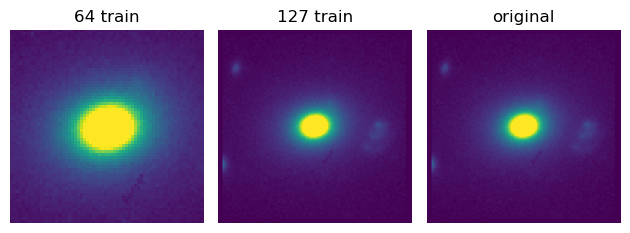

In [42]:
# Check image
hf_original = h5py.File('/data/HSC/HSC_v6/step2/127x127/five_band_image127x127_with_metadata_corrected.hdf5', 'r')
object_id_original = np.asarray(hf_original['object_id'])[..., None]

i = random.randint(0, ntrain)

object_id_64 = np.asarray(hf_train_64['object_id'][0:])[..., None][i][0]
object_id_127 = np.asarray(hf_train_127['object_id'][0:])[..., None][i][0]

for j in range(len(object_id_original)):
    if object_id_original[j] == object_id_64:
        if object_id_original[j] != object_id_127:
            print('error')
        original_index = j

fig, axes = plt.subplots(1, 3)  # 1 row, 2 columns

axes[0].imshow(hf_train_64['image'][i][0], vmin = 0, vmax = 4.16)
axes[0].set_title('64 train')
axes[0].axis('off')

axes[1].imshow(hf_train_127['image'][i][0], vmin = 0, vmax = 4.16)
axes[1].set_title('127 train')
axes[1].axis('off')

axes[2].imshow(hf_original['image'][original_index][0], vmin = 0, vmax = 4.16)
axes[2].set_title('original')
axes[2].axis('off')

plt.tight_layout()
plt.show()

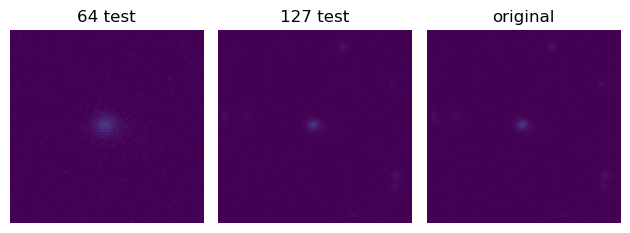

In [44]:
# Check image
hf_original = h5py.File('/data/HSC/HSC_v6/step2/127x127/five_band_image127x127_with_metadata_corrected.hdf5', 'r')
object_id_original = np.asarray(hf_original['object_id'])[..., None]

i = random.randint(0, ntest)

object_id_64 = np.asarray(hf_test_64['object_id'][0:])[..., None][i][0]
object_id_127 = np.asarray(hf_test_127['object_id'][0:])[..., None][i][0]

for j in range(len(object_id_original)):
    if object_id_original[j] == object_id_64:
        if object_id_original[j] != object_id_127:
            print('error')
        original_index = j

fig, axes = plt.subplots(1, 3)  # 1 row, 2 columns

axes[0].imshow(hf_test_64['image'][i][0], vmin = 0, vmax = 4.16)
axes[0].set_title('64 test')
axes[0].axis('off')

axes[1].imshow(hf_test_127['image'][i][0], vmin = 0, vmax = 4.16)
axes[1].set_title('127 test')
axes[1].axis('off')

axes[2].imshow(hf_original['image'][original_index][0], vmin = 0, vmax = 4.16)
axes[2].set_title('original')
axes[2].axis('off')

plt.tight_layout()
plt.show()

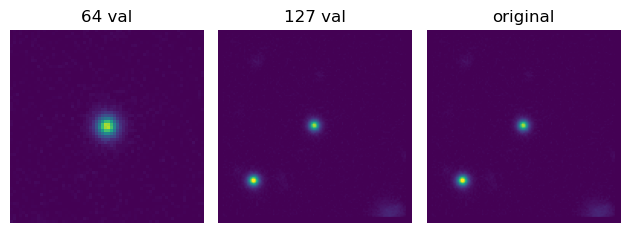

In [45]:
# Check image
hf_original = h5py.File('/data/HSC/HSC_v6/step2/127x127/five_band_image127x127_with_metadata_corrected.hdf5', 'r')
object_id_original = np.asarray(hf_original['object_id'])[..., None]

i = random.randint(0, nval)

object_id_64 = np.asarray(hf_val_64['object_id'][0:])[..., None][i][0]
object_id_127 = np.asarray(hf_val_127['object_id'][0:])[..., None][i][0]

for j in range(len(object_id_original)):
    if object_id_original[j] == object_id_64:
        if object_id_original[j] != object_id_127:
            print('error')
        original_index = j

fig, axes = plt.subplots(1, 3)  # 1 row, 2 columns

axes[0].imshow(hf_val_64['image'][i][0], vmin = 0, vmax = 4.16)
axes[0].set_title('64 val')
axes[0].axis('off')

axes[1].imshow(hf_val_127['image'][i][0], vmin = 0, vmax = 4.16)
axes[1].set_title('127 val')
axes[1].axis('off')

axes[2].imshow(hf_original['image'][original_index][0], vmin = 0, vmax = 4.16)
axes[2].set_title('original')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [46]:
hf_original.close()
hf_train_64.close()
hf_train_127.close()
hf_test_64.close()
hf_test_127.close()
hf_val_64.close()
hf_val_127.close()

In [ ]:
# END